# Photon Flux Estimation Demo

This notebook demonstrates how to use the photon-flux-estimation package to analyze two-photon imaging data from the DANDI archive.

In [1]:
import pynwb
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
import h5py
import fsspec
from fsspec.implementations.cached import CachingFileSystem
import pathlib

from photon_flux_estimation import PhotonFluxEstimator

## Download Data from DANDI

We'll use the MICRONS dataset (000402) from the DANDI archive.

In [2]:
# Set up DANDI client and get dataset URLs
dandiset_id = "000402"  # MICRONS dataset

with DandiAPIClient() as client:
    assets = client.get_dandiset(dandiset_id).get_assets()
    s3_urls = [x.get_content_url(follow_redirects=1, strip_query=True) for x in assets]

# Create a caching scheme for DANDI downloads
cache_path = pathlib.Path('./cache')
cache_path.mkdir(parents=True, exist_ok=True)
fs = CachingFileSystem(fs=fsspec.filesystem("http"), cache_storage=str(cache_path))

A newer version (0.66.4) of dandi/dandi-cli is available. You are using 0.66.3


## Process and Analyze Data

We'll analyze each two-photon series in the dataset using the PhotonFluxEstimator class.

c:\Users\Utente\anaconda3\envs\multiphoton-qc-env\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\Utente\anaconda3\envs\multiphoton-qc-env\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\Utente\anaconda3\envs\multiphoton-qc-env\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Processing d3d1d113-8c11-4baa-85c2-ad707b6b99f3 series 0
Quantal size: 286.75
Zero level: 584.09

Processing d3d1d113-8c11-4baa-85c2-ad707b6b99f3 series 1
Quantal size: 235.74
Zero level: 662.61



KeyboardInterrupt: 

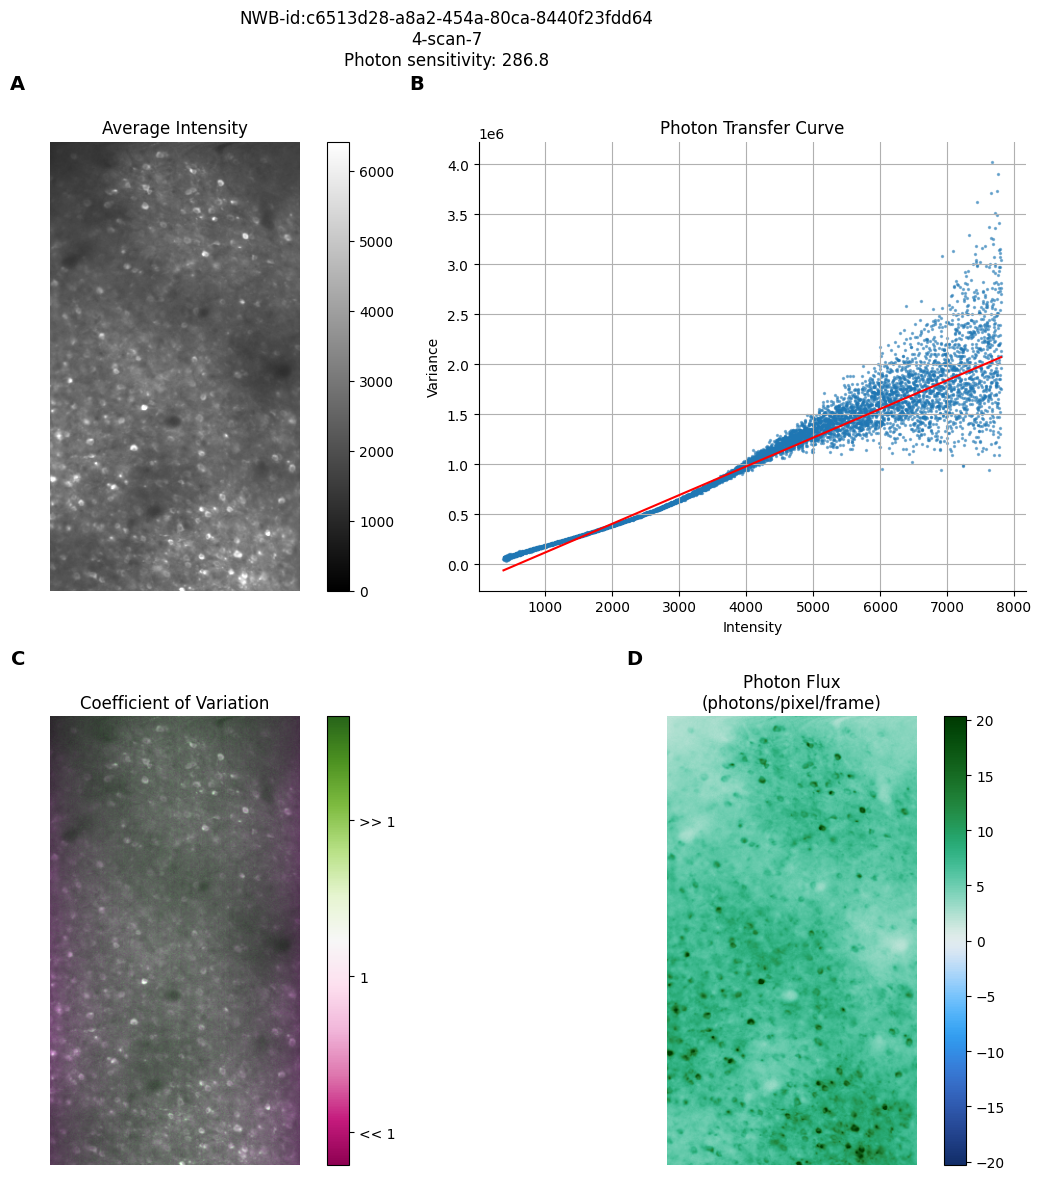

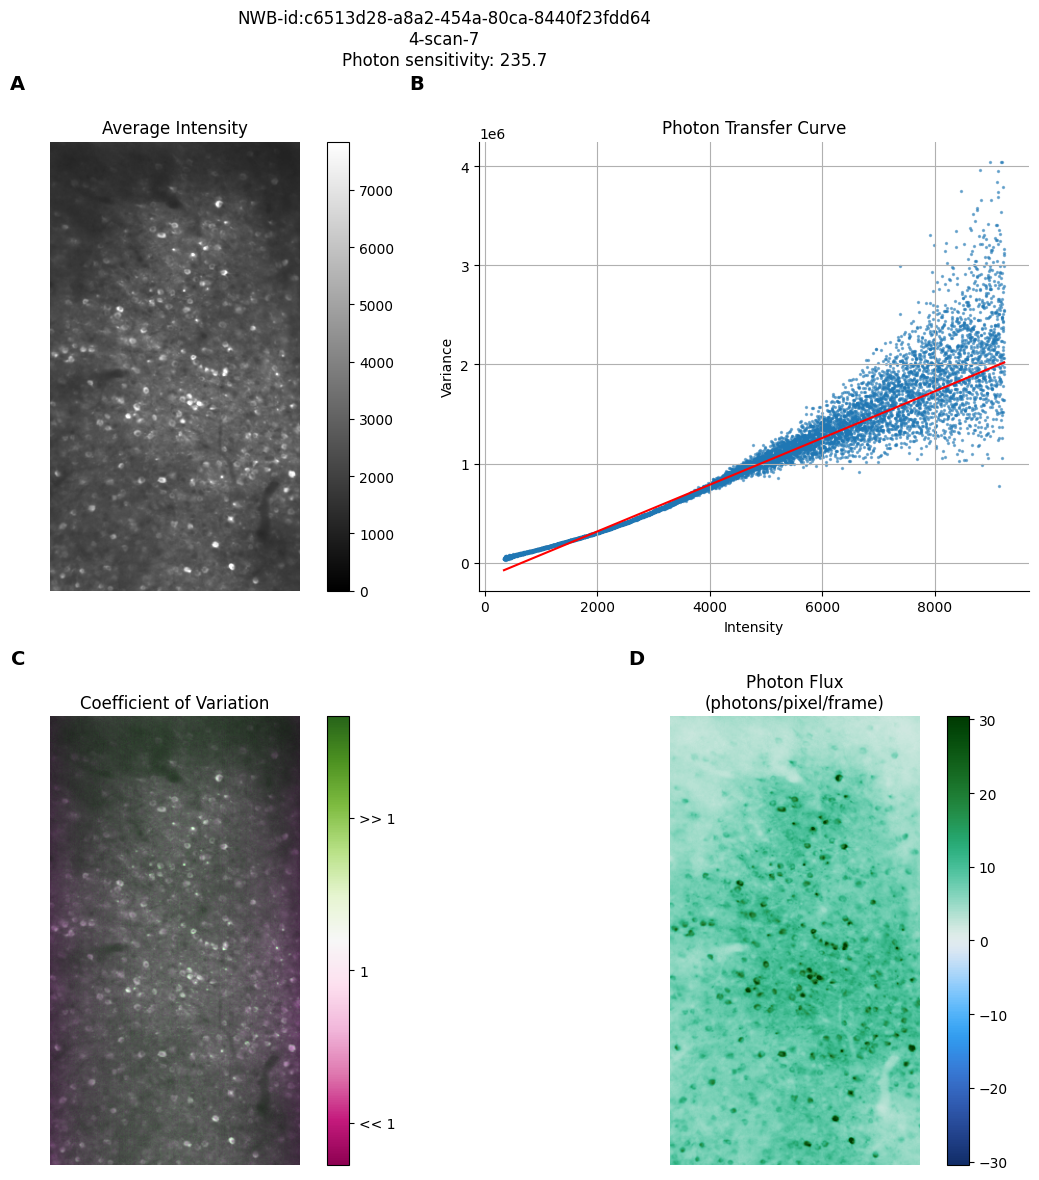

In [3]:
# Create output directory for figures
figure_path = pathlib.Path('./figures')
figure_path.mkdir(parents=True, exist_ok=True)

for url in s3_urls:
    # Open the file
    with fs.open(url, "rb") as f:
        with h5py.File(f) as file:
            with NWBHDF5IO(file=file, load_namespaces=True) as io:
                # Get all two-photon series objects
                collection = (
                    _ for _ in io.read().objects.values() 
                    if isinstance(_, pynwb.ophys.TwoPhotonSeries)
                )

                for count, two_photon_series in enumerate(collection):
                    # Extract a portion of the data (frames 250-750, removing edge artifacts)
                    movie = two_photon_series.data[250:750, 4:-4, 4:-4]
                    movie = movie.transpose(0, 2, 1)
                    
                    try:
                        # Create estimator and compute sensitivity
                        estimator = PhotonFluxEstimator(movie)
                        results = estimator.compute_sensitivity()
                        
                        print(f'Processing {url.split("/")[-1]} series {count}')
                        print(f'Quantal size: {results["sensitivity"]:.2f}')
                        print(f'Zero level: {results["zero_level"]:.2f}\n')
                        
                        # Compute photon flux movie
                        photon_flux = estimator.compute_photon_flux()
                        
                        # Generate and save analysis figure
                        title = f"NWB-id:{two_photon_series.get_ancestor().identifier}\n{two_photon_series.get_ancestor().session_id}"
                        save_path = figure_path / f"{url.split('/')[-1]}-{count:03}.png"
                        estimator.plot_analysis(title=title, save_path=save_path)
                        
                    except Exception as e:
                        print(f'Error processing series {count}: {e}\n')

## Interpreting the Results

For each two-photon series, the estimator generates a figure with four panels:

1. **Average Intensity**: Shows the mean intensity across all frames, providing a baseline view of the imaging field.

2. **Photon Transfer Curve**: Plots intensity vs variance to estimate sensitivity. The slope of this curve gives us the photon sensitivity (gain) of the system.

3. **Coefficient of Variation**: Visualizes the noise characteristics across the field of view. Areas with CV ≈ 1 indicate shot-noise limited detection.

4. **Photon Flux**: Shows estimated photons per pixel per frame after correcting for the system's sensitivity and zero level.

The sensitivity value (gain) represents how many intensity units correspond to one photon. The zero level (offset) indicates the baseline intensity when no photons are detected.

This analysis helps characterize the imaging system's performance and provides calibrated photon flux estimates from raw intensity measurements.